In [365]:
from IPython.display import Image
#Image(filename='images/aiayn.png')

Le Transformer de ["Attention is All You Need"](https://arxiv.org/abs/1706.03762) a été utilisé par énorménent de chercheurs au cours de la dernière année. En plus de produire des améliorations majeures de la qualité de la traduction, il fournit une nouvelle architecture pour de nombreuses autres tâches de NLP. Le document lui-même est très clairement écrit, mais la sagesse conventionnelle veut qu'il soit assez difficile à mettre en œuvre correctement.

Dans cet article, je présente une version «annotée» du document sous la forme d'une implémentation ligne par ligne. J'ai réorganisé et supprimé certaines sections de l'article d'origine et ajouté des commentaires tout au long. Ce document lui-même est un cahier de travail et devrait être une implémentation complètement utilisable. Au total, il y a 400 lignes de code de bibliothèque qui peuvent traiter 27 000 jetons par seconde sur 4 GPU.

Pour suivre, vous devrez d'abord installer [PyTorch](http://pytorch.org/). Le bloc-notes complet est également disponible sur github ou sur Google [Colab](https://drive.google.com/file/d/1xQXSv6mtAOLXxEMi8RvaW8TW-7bvYBDF/view?usp=sharing) avec des GPU gratuits.

Notez que ce n'est qu'un point de départ pour les chercheurs et les développeurs intéressés. Le code ici est fortement basé sur nos packages OpenNMT. (Si utile, n'hésitez pas à citer.) Pour d'autres implémentations complètes du modèle, consultez Tensor2Tensor (tensorflow) et Sockeye (mxnet).

Alexander Rush (@harvardnlp ou srush@seas.harvard.edu), avec l'aide de Vincent Nguyen et Guillaume Klein

# Prelims

In [366]:
# !pip install torch torchvision numpy matplotlib spacy torchtext seaborn 

In [367]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context='talk')
%matplotlib inline

# Background

L'objectif de réduire le calcul séquentiel constitue également la base du GPU Neural étendu, ByteNet et ConvS2S, qui utilisent tous des réseaux de neurones convolutionnels comme élément de base, calculant des représentations cachées en parallèle pour toutes les positions d'entrée et de sortie. Dans ces modèles, le nombre d'opérations nécessaires pour relier les signaux de deux positions d'entrée ou de sortie arbitraires augmente dans la distance entre les positions, linéairement pour ConvS2S et logarithmiquement pour ByteNet. Cela rend plus difficile l'apprentissage des dépendances entre des positions éloignées. Dans le transformeur, cela est réduit à un nombre constant d'opérations, mais au prix d'une résolution effective réduite en raison de la moyenne des positions pondérées par l'attention, un effet que nous neutralisons avec l'attention multi-têtes.

L'auto-attention, parfois appelée intra-attention, est un mécanisme d'attention reliant différentes positions d'une même séquence afin de calculer une représentation de la séquence. L'auto-attention a été utilisée avec succès dans une variété de tâches, notamment la compréhension de la lecture, le résumé abstractif, l'implication textuelle et l'apprentissage de représentations de phrases indépendantes des tâches. Les réseaux de mémoire (LSTM, GRU)) sont basés sur un mécanisme d'attention récurrente au lieu d'une récurrence alignée en séquence et se sont avérés performants sur la réponse aux questions en langage simple et
tâches de modélisation du langage.

Au meilleur de nos connaissances, le transformateur est le premier modèle de traduction reposant entièrement sur l'auto-attention pour calculer les représentations de ses entrées et sorties sans utiliser de RNN alignés en séquence ou de convolution.

# Model architcture

La plupart des modèles de transduction de séquence neuronale compétitifs ont une structure encodeur-décodeur [(cite)](https://arxiv.org/abs/1409.0473). Ici, l'encodeur mappe une séquence d'entrée de représentations de symboles $(x_1, ..., x_n)$ à une séquence de représentations continues $\mathbf{z} = (z_1, ..., z_n)$. Etant donné z, le décodeur génère alors une séquence de sortie $(y_1,...,y_m)$ de symboles pour un élément à la fois. À chaque étape, le modèle est auto-régressif (cite), consommant les symboles générés précédemment comme entrée supplémentaire lors de la génération des modèles suivants.

In [368]:
class EncoderDecoder(nn.Module):
    """
    A standard encoder-Decoder architecture. Base for this and many other models.import
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, src_mask, tgt, tgt_mask):
        "take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
    

In [369]:
class Generator(nn.Module):
    "Défini une étape feed-foward + softmax."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        "dim = -1 permet d'appeler la dernière dimension de x quelque soit sa dimension"
        return F.log_softmax(self.proj(x), dim=-1) 

Le transformeur suit cette architecture globale en utilisant des couches d'auto-attention empilées et point à point, entièrement connectées pour le codeur et le décodeur, illustrées respectivement dans les moitiés gauche et droite de la figure 1.

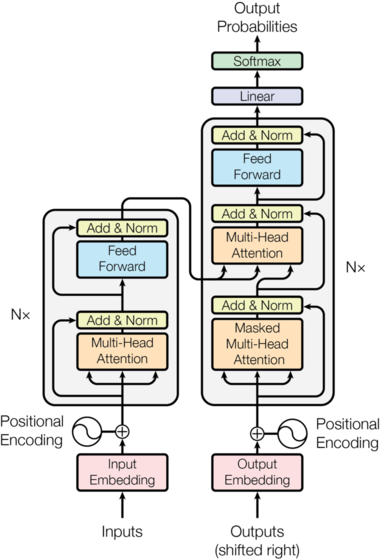

In [370]:
Image(filename='images/ModalNet-21.png')

# Encodeur et Decodeur 

##Encodeur

l'encodeur est composée d'une pile de 6 blocs identiques

In [371]:
def clones(module, N):
    "Produire N blocs identiques"
    return nn.ModuleList([copy.deepcopy(module) for _ in range (N)])

In [372]:
class Encoder(nn.Module):
    "l'encodeur est une pile de N bloc"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass successivement l'entrée (et le masque) à travers chaque blocs."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

Nous ajoutons une connection résiduelle [(cite)](https://arxiv.org/abs/1512.03385) à chacun des 2 sous blocs, avant d'effectuer leurs normalisations [(cite)](https://arxiv.org/abs/1607.06450).  

In [373]:
class LayerNorm(nn.Module):
    "constuction du module de normalisation des sous blocs "
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim = True)
        std = x.std(-1, keepdim = True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

Ainsi, la sortie de chaque sous-bloc est $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, où $\mathrm{Sublayer}(x)$ est une fonction implémenté par le sous-bloc lui-même. Nous appliquerons du dropout [(cite)](http://jmlr.org/papers/v15/srivastava14a.html) au sortie de chaque sous bloc avant l'ajout du résidu et la normalisation.

Pour faciliter cette connection résiduelle, tous les sous bloc du modèle, ainsi que le bloc d'embedding, ont des matrices de sortie de $d_{\text{model}}=512$.

In [374]:
class SublayerConnection(nn.Module):
    """
    Une connection résiduelle suivit pas une LayerNorm.
    pour la simplicité du modèle on applique la normalisation avant la connection
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Effectue la connection résiduelle pour tous les sous blocs de taille = dmodel"
        return x + self.dropout(sublayer(self.norm(x)))

Chaque bloc a deux sous bloc. le premier est une multi-head self-attention mécanisme, et le second est un réseau feed-foward profond (qui prend en compte la position des inputs d'entrée). 

In [375]:
class EncoderLayer(nn.Module):
    "Un bloc d'encodeur est composé de self-attention et d'un feed_foward"
    def __init__(self, size, self_attn, feed_foward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_foward = feed_foward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "suivre la figure 1 (gauche) pour l'interconnection entre sous bloc"
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_foward)

### Decodeur


Le décodeur est également composé d'une pile de N = 6 blocs identiques

In [376]:
class Decoder(nn.Module):
    "N générique bloc décodeur avec mask"
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [377]:
class DecoderLayer(nn.Module):
    "un bloc de decodeur est composé de self-attn, src-attn, feed follow (defini ci-dessous)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size,dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "suivre la figure 1 (droite)"
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.self_src(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [378]:
def subsequent_mask(size):
    "mask la position suivante"
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

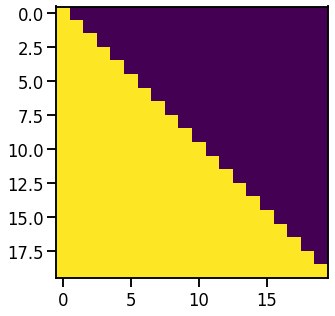

In [379]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

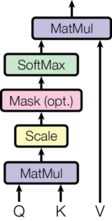

In [380]:
'scaled dot-product attention'
Image(filename='images/ModalNet-19.png')

### Attention

Une fonction d'attention peut être décrite comme mappant une requête et un ensemble de paires clé-valeur à une sortie, où la requête, les clés, les valeurs et la sortie sont tous des vecteurs. La sortie est calculée comme une somme pondérée des valeurs, où le poids attribué à chaque valeur est calculé par une fonction de compatibilité de la requête avec la clé correspondante.

Nous appelons notre attention "Scaled Dot-Product Attention". les entrées sont des réquetes et clés de dimensions $d_k$ et des valeurs de dimensions $d_v$. Nous calculons le produit scalaire entre la réquête et tous les clés, divisons chaque résultat par $\sqrt{d_k}$, et appliquons une fonction softmax pour obtenir un poids une chaque valeur correspondant au clé.                                                              

En pratique, nous calculons une fonction d'attention sur un ensemble de requête simultanément, combinées dans une matrice $Q$. Les clés et les valeurs sont aussi combinées respectivement dans des matrices $K$ and $V$. Nous calculons la matric de sortie de la manière suivantes:                                         
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$   

In [381]:
def attention(query, key, value, mask=None, dropout=None):
    "calcul 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2,-1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


Les deux fonctions d'attention les plus couramment utilisées sont l'attention additive [(cite)] (https://arxiv.org/abs/1409.0473) et l'attention du produit scalaire (multiplicative). L'attention du produit scalaire est identique à notre algorithme, à l'exception du facteur d'échelle de $\frac {1}{\ sqrt {d_k}}$. L'attention additive calcule la fonction de compatibilité à l'aide d'un réseau feed-forward avec une seule couche cachée. Bien que les deux soient similaires en termes de complexité théorique, l'attention accordée aux produits scalaires est beaucoup plus rapide et plus économe en espace dans la pratique, car elle peut être mise en œuvre à l'aide d'un code de multiplication de matrice hautement optimisé.

                                                                        
Alors que pour les petites valeurs de $d_k$, les deux mécanismes fonctionnent de manière similaire, l'attention additive surpasse l'attention du produit scalaire sans mise à l'échelle pour les valeurs plus élevées de $d_k$ [(cite)](https://arxiv.org/abs/1703.03906. Nous soupçonnons que pour les grandes valeurs de $d_k$, les produits scalaires explosent, ce qui pousse la fonction softmax dans les régions où elle présente des gradients extrêmement faibles (pour illustrer pourquoi les produits scalaires deviennent volumineux, supposons que les composants de $ q $ et $ k $ sont des variables aléatoires indépendantes avec une moyenne de $ 0 $ et une variance $ 1 $. Ensuite, leur produit scalaire, $ q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, a une moyenne de $0$ et une variance $d_k$ .). Pour contrer cet effet, nous normalisons les produits scalaires par $\frac{1} {\sqrt{d_k}}$.

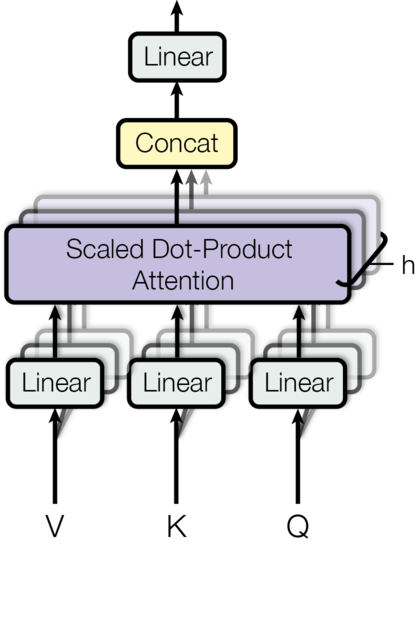

In [382]:
Image(filename='images/ModalNet-20.png')

L'attention multi-têtes permet au modèle d'apprendre conjointement à plusieurs types d'informations pour une valeur $V$ partant des mêmes positions de la requêtes. Avec une seule tête d'attention, la moyenne inhibe cela.
$$
\mathrm{MultiHead} (Q, K, V) = \mathrm{Concat} (\mathrm{head_1},...,\mathrm{head_h}) W^O 
\\
    \text{where} ~ \mathrm{head_i} = \mathrm{Attention} (QW^Q_i, KW^K_i, VW^V_i)
$$

Où les projections sont des matrices de paramètres $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{modèle}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ et $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}} $. Dans ce travail, nous utilisons $ h = 8 $ couches d'attention parallèles, ou têtes. Pour chacun d'eux, nous utilisons $ d_k = d_v = d _ {\ text {model}} / h = 64 $. En raison de la dimension réduite de chaque tête, le coût de calcul total est similaire à celui de l'attention d'une seule tête avec une dimensionnalité complète.

In [383]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Prend la taille du model et le nombre h d'attention"
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implemente Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

### Applications de l'Attention dans notre modèle


Le Transformer utilise les multi-head d'attention de 3 différentes manières:
                               
1) Dans le bloc "encoder-decoder attention", les requêtes arrivent du bloc decodeur précédent, et les réprésentations clés, valeurs arrivent des sorties du bloc encodeur.
Cela permet à chaque bloc du decodeur d'accéder à toutes les positons de la séquence d'entrée. Cela imite les mécanismes d'attention encodeur-décodeur typiques dans les modèles de séquence à séquence tels que [(cite)](https://arxiv.org/abs/1609.08144).    


2) L'encodeur contient des sous blocs de self-attention. Dans un bloc de self-attention toutes les clés, valeurs et requêtes viennent du même endroit, qui est dans notre cas les blocs précédents de l'encodeur. Chaque position d'un bloc de l'encodeur peut avoir accès à toutes les positions du bloc précédent.         


3) De la même manière, les blocs de self-attention du decodeur peuvent avoir accès à toutes les positions du bloc précédent. Nous devons empêcher le flux d'informations vers la gauche dans le décodeur pour préserver sa propriété auto-régressive [(cite)](https://www.cs.toronto.edu/~amnih/papers/darn.pdf) . Nous implémentons cela à l'intérieur du "Scaled Dot-Product" scalaires en masquant (en définissant $-\infty$) toutes les valeurs dans l'entrée du softmax qui correspondent à des connexions illégales.
                                                                                       

## Feed-Forward Positionnel (Positon-wise) 

                   
En addition au sous-bloc d'attention, chaque bloc de l'encodeur et du décodeur sont entièrement connectés à un réseau feed-forward, qui s'applique à chaque position de la sortie du sous-bloc de manière identique. Le feed-forward effectue deux transformations linéaires avec une activation ReLU entre les deux.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                                                                                     

 
Bien que les transformatons linéaires soient les mêmes dans différentes positions d'un bloc, elles utilisent des paramètres différents d'un bloc à l'autre. Les dimensions d'entrées et de sorties sont $d_{\text{model}}=512$, et celle la couche intra FFN à une dimensionalité de  $d_{ff}=2048$. 

In [384]:
class PositionwiseFeedForward(nn.Module):
    "Implement FFN équation"
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings and Softmax 


De manière similaire à d'autres modèles de transduction de séquence, nous utilisons des plongements lexicaux (embedding) appris pour convertir les séquences d'entrée et de sortie en vecteurs de dimension $d_{\text{model}}$.

Nous utilisons également la transformation linéaire apprise et la fonction softmax habituelles pour convertir la sortie du décodeur en probabilités pour prédire la prochaine partie de la séquence. Dans notre modèle, nous partageons la même matrice de poids entre les deux blocs d'Embeddings et la transformation linéaire pré-softmax, similaire à [(cite)] (https://arxiv.org/abs/1608.05859). Dans les blocs d'embedding, nous multiplions ces poids par $\sqrt{d_{\text{model}}}$.

In [385]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding

Puisque notre modèle ne contient aucune récurrence, ni convolution, pour que le modèle utilise l'ordre de la séquence, nous devons injecter des informations sur la position relative ou absolue des éléments dans la séquence.

A cette fin, nous ajoutons un encodage positionnel au bloc d'embeddings d'entrée au bas des blocs d'en et de decodeur. Les encodages positionnels ont la même dimension $d_{\text{model}$ que les blocs d'embeddings, de sorte que les deux peuvent être additionnés. Il existe de nombreux choix d'encodages positionnels, appris et corrigés [(cite)] (https://arxiv.org/pdf/1705.03122.pdf).

Nous utiliserons des fonctions sinusoid et cosinus de fréquences différentes:                                  
$$PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})$$

où $pos$ est la position et $i$ la dimension. Ainsi, chaque dimension de l'encodeur positionnel correspond à une courbe sinusoidal. 

Les longueurs d'onde forment une progression géométrique de $2\pi$ à $10000 \cdot 2\pi$. Nous avons choisi cette fonction car nous avons émis l'hypothèse qu'elle permettrait au modèle d'apprendre facilement à accéder aux positions relatives, car pour tout décalage fixe $k$, $PE_{pos + k}$ peut être représenté comme une fonction linéaire de $PE_{pos}$.

De plus, nous appliquons du dropout aux sommes des plongements et des encodages de position de l'encodeur et du décodeur. Pour le modèle de base, nous utilisons un taux de $P_{drop} = 0,1$.

In [386]:
class PositionalEncoding(nn.Module):
    "Implement l'encoding positonnal"
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # calcul d'encoding postional 
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)],
                         requires_grad=False)
        return self.dropout(x)

> En plus de l'encodage positionnel, une onde sinusoïdale sera ajoutée en fonction de la position. La fréquence et le décalage de l'onde sont différents pour chaque dimension.

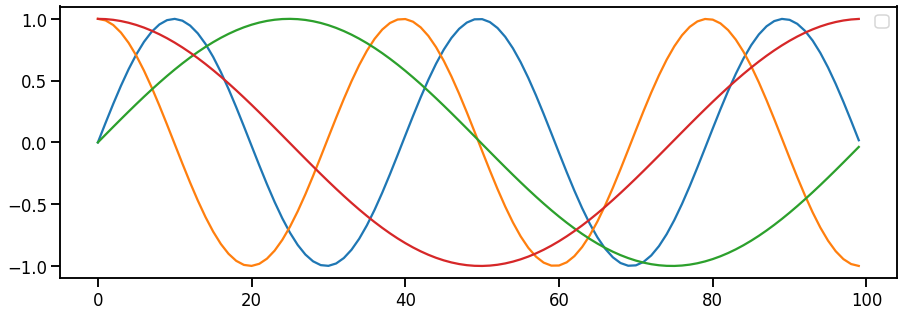

In [387]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend("dim %d"%p for p in [4,5,6,7])
None

Nous avons également expérimenté l'utilisation des embeddings positionnelles apprises [(cite)] (https://arxiv.org/pdf/1705.03122.pdf) à la place, et nous avons constaté que les deux versions produisaient des résultats presque identiques. Nous avons choisi la version sinusoïdale car elle peut permettre au modèle d'extrapoler à des longueurs de séquence plus longues que celles rencontrées lors de l'entraînement.

## Full Model

> Ici nous definisons une fonction des hyperpametres vers un model entier

In [388]:
def make_model(src_vocab, tgt_vocab, N=6,
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Aide: Construction d'un modèle à partir des hyperamètres"
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    positon = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(positon)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(positon)),
        Generator(d_model, tgt_vocab))

    # this was important forom their code
    # Initialisation des paramètres avec Glorot / fan_zvg
    for p in model.parameters():
        if p.dim() > 1: 
            nn.init.xavier_uniform_(p)
    return model

In [389]:
#Example model
tmp_model = make_model(10, 10, 2)
tmp_model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_foward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()


# Training

Cette section descrit l'entrainement de notre modèle



> Nous nous arrêtons pour un bref intermède pour présenter certains des outils nécessaires pour former un modèle d'encodeur décodeur standard. Nous définissons d'abord un objet batch qui contient le src et les phrases cibles pour la formation, ainsi que la construction des masques. 

## Batches and Masking

In [390]:
class Batch:
    "Objet permettant de mettre des données en batch pour les éléments masquées"
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Crée une masque pour cacher le padding and les futurs mots"
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask 

> Ensuite, nous créons une fonction générique d'entrainement et d'évaluation. Nous transmettons une fonction de perte générique qui gère également les mises à jour des paramètres.

## Training Loop

In [391]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0 
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        if i % 50 == 1:
            elpased = time.time() - start
            print("Epoch Step: %d Loss %f Tokens per Sec: %f" % 
                    (i, loss / batch.ntokens, tokens / elpased))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

## Training Data and Batching

Nous entrainons sur un dataset standard WMT 2014 English-German contenant environ 4.5 million de paires de phrases. les phrases sont encodées par byte_pair, lequel partage un vocabulary source-cible de 37000 mot. Pour la tranduction Anglais-Français, nous utilisons
WMT 2014 anglais-Français contenant 36M dd phrases (paires) splité en element. (32000 word-piece vocabulary).

Les paires de phrases sont mises en batch ensemble avec une taille fixe par séquence.
Chaque batch d'entrainement contient un ensemble de pairs de phrases avec environ 50000 mots (source-cible)
Sentence pairs were batched together by approximate sequence length.  Each training batch contained a set of sentence pairs containing approximately 25000 source tokens and 25000 target tokens.     

> Nous utiliserons torch text pour la mise en batch. Nous en parlerons plus loin. Ici, nous créons des lots dans une fonction torchtext qui garantit que notre taille de lot rembourrée à la taille de lot maximale ne dépasse pas un seuil (25000 si nous avons 8 gpus.

In [392]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_in(new, count, sofar):
    "Augmente taille du batch et calcule le nombre total de tokens + pad"
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.tgt) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

## Hardware and Schedule

Nous avons entrainé notre modèle sur une seule machine avec 8 GPU NVIDIA P100. Pour nos modèles de base utilisant les hyperparamètres décrits dans le document, chaque étape de formation a duré environ 0,4 seconde. Nous avons entrainé les modèles de base pour un total de 100 000 epochs ou 12 heures. Pour notre grand modèle, le temps par epoch était de 1,0 seconde pour une total de 300 000 epochs (3,5 jours).                                 

## Optimizer

Nous utilisons l'optimseur Adam [(cite)](https://arxiv.org/abs/1412.6980) avec   $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$. Nous faisons vairé le taux d'apprentissage suivaint cette formule:   

$$                                                                                                     
lrate = d_{\text{model}}^{-0.5} \cdot\min({step\_num}^{-0.5},{step\_num} \cdot          {warmup\_steps}^{-1.5})                                                                                                                                                                                                                                                                               
$$  


Cela correspond à une augmentation linéaire du taux d'apprentissage pour les premiers epochs d'entraînement $warmup\_steps$, puis à une diminution proportionnelle à la racine carrée inverse du nombre d'epochs. Nous avons utilisé $warmup\_steps = 4000$.

In [393]:

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

> Exemple de courbes de ce modèle pour différentes tailles de modèle et pour l'optimisation d'hyperparamètres.

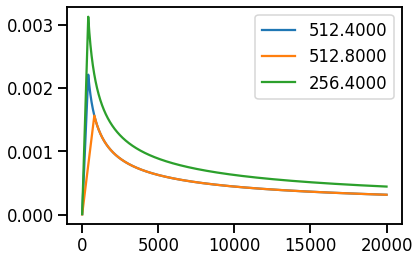

In [394]:
# 3 parametrage differents pour visualiser l'evolution du taux d'apprentissae
opts = [NoamOpt(512, 1, 400, None),
        NoamOpt(512, 1, 800, None),
        NoamOpt(256, 1, 400, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512.4000", "512.8000", "256.4000"])
None

## Regularization
                                     
### Label Smoothing

Pendant la phase d'entrainement, nous avons utilisé un lissage d'étiquette de valeur $\epsilon_{ls} = 0,1$ [(cite)] (https://arxiv.org/abs/1512.00567). Cela augmente la perplexité, car le modèle apprend à être plus incertain, mais améliore la précision et le score BLEU.

> Nous réalisons le lissage des étiquettes en utilisant la perte KL div. Au lieu d'utiliser une distribution cible unique, nous créons une distribution qui a la «confiance» du mot correct et le reste de la masse de «lissage» distribuée dans tout le vocabulaire.

In [395]:
class LabelSmoothing(nn.Module):
    "Implement le lissage "
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size -2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

> Ici, nous pouvons voir un exemple de la façon dont la masse est distribuée aux mots en fonction de la confiance.

In [396]:
#Exemple of label smoothing
crit =  LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0]])

v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Montre la distribution s cibles expérer par le système
#plt.imshow(crit.true_dist)
None

> Le lissage des étiquettes commence en fait à pénaliser le modèle s'il devient très confiant sur un choix donné.

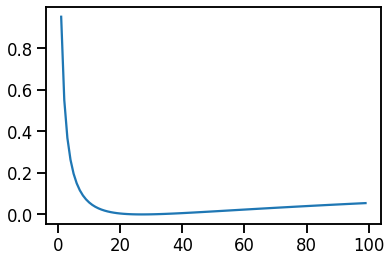

In [397]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).data

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

# Premier simple



> Nous pouvons commencer par essayer une simple tâche de copie. Étant donné un ensemble aléatoire de symboles d'entrée à partir d'un petit vocabulaire, l'objectif est de recréer ces mêmes symboles.


In [398]:
def data_gen(V, batch, nbatches):
    "genère des données aléatoires pour src-tgt tâches de copies"
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

## Loss Computation

In [399]:
class SimpleLossCompute:
    "calcul de loss et train function "
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1)) / norm

        loss.bachward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.data[0] * norm

## Greedy Decoding

In [400]:
# Entrainement pour une simple tâche de copie
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
                torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

RuntimeError: The size of tensor a (9) must match the size of tensor b (10) at non-singleton dimension 3